### Importing necessary libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [13]:
X, y = np.array(mnist.data), np.array(mnist.target)

In [14]:
y = y.astype(np.uint8)

In [15]:
arr = np.array(mnist['data'])

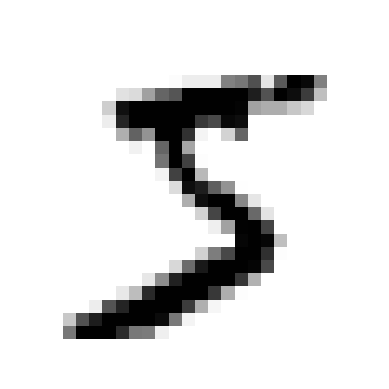

In [16]:
import matplotlib as mpl
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [17]:
y[0]

np.uint8(5)

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [19]:
 y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits.
 y_test_5 = (y_test == 5)

In [20]:
 from sklearn.linear_model import SGDClassifier
 sgd_clf = SGDClassifier(random_state=42)
 sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [21]:
sgd_clf.predict(X[0].reshape(1,-1))

array([ True])

## Performance Measures

### Applying cross validation

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


### Reason why accuracy is not good matrix for  classification

In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [24]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
     pass
 def predict(self, X):
     return np.zeros((len(X), 1), dtype=bool)

In [25]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

 This demonstrates why accuracy is generally not the preferred performance measure
 for classifiers, especially when you are dealing with skewed datasets (i.e., when some
 classes are much more frequent than others)

## Confusion Matrix

In [26]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [28]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [29]:
from sklearn.metrics import precision_score, recall_score
print("precision_score ",precision_score(y_train_5, y_train_pred), "\nrecall_score ",recall_score(y_train_5, y_train_pred))

precision_score  0.8370879772350012 
recall_score  0.6511713705958311


In [30]:
from sklearn.metrics import f1_score
print('f1 score:',f1_score(y_train_5, y_train_pred))

f1 score: 0.7325171197343847


In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

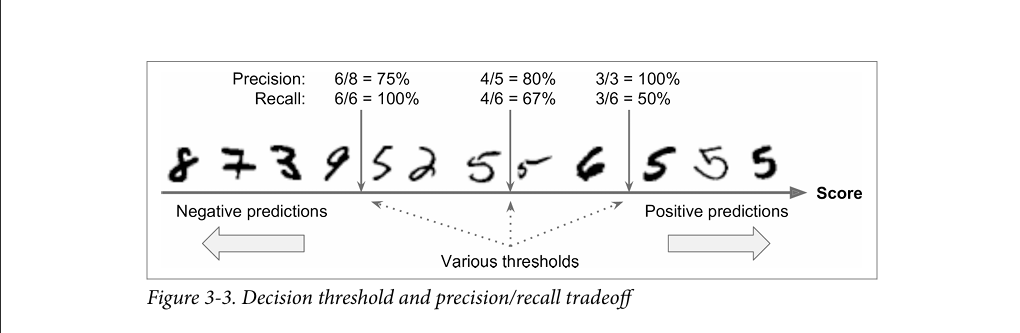

In [32]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred, y[0]

(array([False]), np.uint8(5))

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000

In [33]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
 method="decision_function")

In [34]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

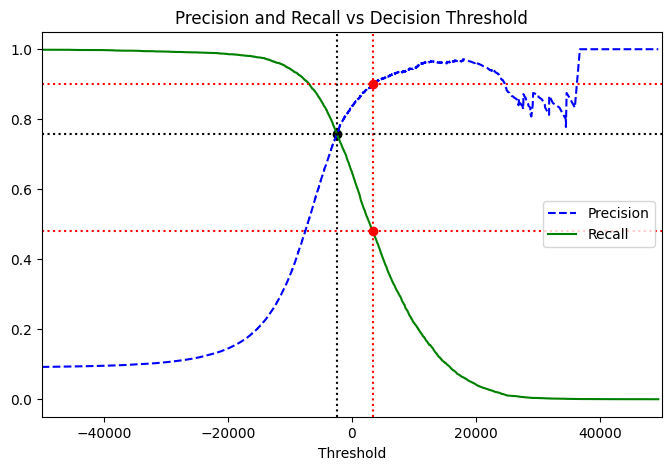

np.int64(54579)

In [35]:
def plot_precision_recall_vs_threshold(precision, recall, thresholds, target_precision):
# Plot Precision-Recall vs Threshold
    plt.figure(figsize=(8, 5))
    # Trim precision & recall to match thresholds
    precision = precision[:-1]
    recall = recall[:-1]
    plt.plot(thresholds, precision, 'b--', label="Precision")  # Dashed blue line for precision
    plt.plot(thresholds, recall, 'g-', label="Recall")  # Solid green line for recall

    closest_idx = np.argmin(np.abs(precision - target_precision))
    optimal_idx = np.argmin(np.abs(precision - recall))
    plt.scatter(thresholds[closest_idx], precision[closest_idx], color='red', zorder=3)
    plt.scatter(thresholds[closest_idx], recall[closest_idx], color='red', zorder=3)
    
    plt.scatter(thresholds[optimal_idx], recall[optimal_idx], color='k', zorder=1)

    # Add grid, labels, and legend
    plt.axvline(thresholds[closest_idx], color='red', linestyle='dotted')
    plt.axhline(precision[closest_idx], color='red', linestyle='dotted')
    plt.axhline(recall[closest_idx], color='red', linestyle='dotted')
    
    plt.axvline(thresholds[optimal_idx], color='k', linestyle=':')
    plt.axhline(precision[optimal_idx], color='k', linestyle=':')

    plt.xlabel("Threshold")
    plt.legend()
    plt.xlim(-50000,50000)
    plt.title("Precision and Recall vs Decision Threshold")
    plt.show()
    return (optimal_idx)

plot_precision_recall_vs_threshold(precisions , recalls, thresholds, 0.90)

In [36]:
 threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816
 threshold_90_precision

np.float64(3370.0194991439557)

In [37]:
 y_train_pred_90 = (y_scores >= threshold_90_precision)
 y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [38]:
print("precision_score ",precision_score(y_train_5, y_train_pred_90), "\nrecall_score ",recall_score(y_train_5, y_train_pred_90))

precision_score  0.9000345901072293 
recall_score  0.4799852425751706


If someone says “let’s reach 99% precision,” you should ask, “at what recall?”

## The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead  the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity

In [39]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

np.float64(0.2014388489208633)

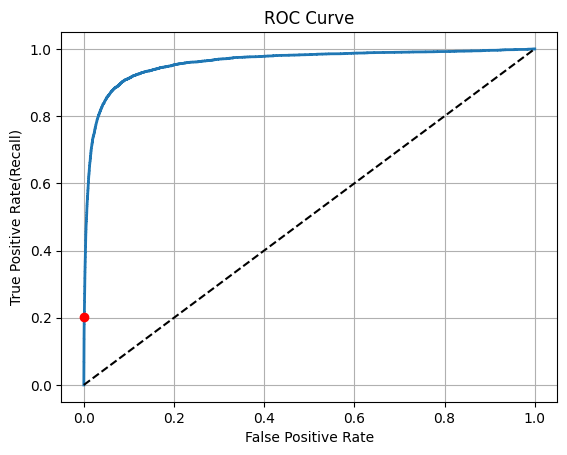

In [56]:
def plot_roc_curve(fpr, tpr, label=None):    
    # Plot ROC curve
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
    
    # Find max TPR when FPR is still 0
    max_tpr_at_zero_fpr = np.max(tpr[fpr < 0.001])  # Maximum TPR when FPR is 0

    # Scatter point at (0, max_tpr_at_zero_fpr)
    plt.scatter(0, max_tpr_at_zero_fpr, color='red', zorder=3, label='(0, max TPR)')

    plt.ylabel('True Positive Rate(Recall)')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.title('ROC Curve')

plot_roc_curve(fpr, tpr)
divergence_idx=0
for i in range(3600, len(fpr)):
    if tpr[i] > tpr[i - 1]:  # First increase in FPR
        divergence_idx = i
        break
fpr[divergence_idx],  tpr[divergence_idx], divergence_idx
    # Find max TPR when FPR is still 0
max_tpr_at_zero_fpr = np.max(tpr[fpr <0.001])  # Maximum TPR when FPR is 0
max_tpr_at_zero_fpr

the higher the recall (TPR), the more false positives (FPR) the classifier produces.
The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner)

 A per
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
 have a ROC AUC equal to 0.5.
 As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than
 the false negatives, and the ROC curve otherwise.

In [41]:
 from sklearn.metrics import roc_auc_score
 roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [42]:
 from sklearn.ensemble import RandomForestClassifier
 forest_clf = RandomForestClassifier(random_state=42)
 y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
 method="predict_proba")

In [43]:
 y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
 fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

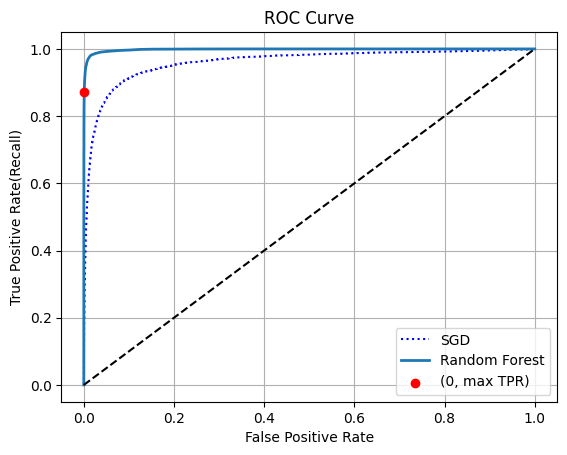

In [57]:
 plt.plot(fpr, tpr, "b:", label="SGD")
 plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
 plt.legend(loc="lower right")
 plt.show()

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

## Multi-Class Classification
Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
 capable of handling multiple classes directly. Others (such as Support Vector Machine
 classifiers or Linear classifiers) are strictly binary classifiers.

In [46]:
sgd_clf.fit(X_train, y_train)  # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [48]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [49]:
np.argmax(some_digit_scores)

np.int64(3)

In [50]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value.

In [51]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
 len(ovo_clf.estimators_)

45

In [59]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [60]:
 forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
 forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [62]:
 cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_train_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

In [72]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [70]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

KeyboardInterrupt: 

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

ZeroDivisionError: integer division or modulo by zero

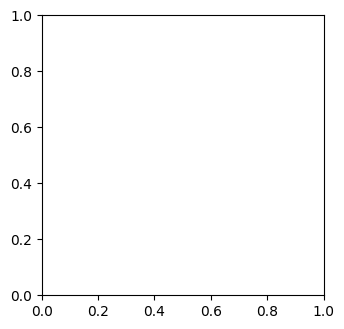

In [73]:
 cl_a, cl_b = 3, 5
 X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
 X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
 X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
 X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
 plt.figure(figsize=(8,8))
 plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
 plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
 plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
 plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
 plt.show()

In [75]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

KeyboardInterrupt: 

In [76]:
 from sklearn.neighbors import KNeighborsClassifier
 y_train_large = (y_train >= 7)
 y_train_odd = (y_train % 2 == 1)
 y_multilabel = np.c_[y_train_large, y_train_odd]
 knn_clf = KNeighborsClassifier()
 knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [77]:
 knn_clf.predict([some_digit])

array([[False,  True]])

In [78]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

np.float64(0.9764102655606048)

In [80]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

np.float64(0.9778357403921755)

This assumes that all labels are equally important, which may not be the case. In par
ticular, if you have many more pictures of Alice than of Bob or Charlie, you may want
 to give more weight to the classifier’s score on pictures of Alice. One simple option is
 to give each label a weight equal to its support (i.e., the number of instances with that
 target label). To do this, simply set average="weighted" in the preceding code.

In [79]:
np.c_?

Type:        CClass
String form: <numpy.lib._index_tricks_impl.CClass object at 0x0000011AF49D0A70>
Length:      0
File:        c:\users\krrish\appdata\local\programs\python\python312\lib\site-packages\numpy\lib\_index_tricks_impl.py
Docstring:  
Translates slice objects to concatenation along the second axis.

This is short-hand for ``np.r_['-1,2,0', index expression]``, which is
useful because of its common occurrence. In particular, arrays will be
stacked along their last axis after being upgraded to at least 2-D with
1's post-pended to the shape (column vectors made out of 1-D arrays).

See Also
--------
column_stack : Stack 1-D arrays as columns into a 2-D array.
r_ : For more detailed documentation.

Examples
--------
>>> np.c_[np.array([1,2,3]), np.array([4,5,6])]
array([[1, 4],
       [2, 5],
       [3, 6]])
>>> np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
array([[1, 2, 3, ..., 4, 5, 6]])

##  Multioutput / Multi-Class Classification